# 2-Photon Microscopy of Larval Zebrafish 

## Step 1: Load and preparing data.

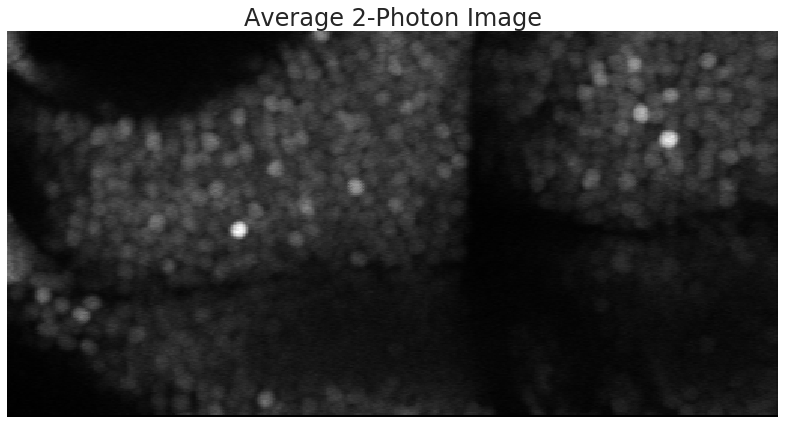

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.external import tifffile
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'fish008.tif'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
tiff = tifffile.imread('raw/%s' %f)

## Assemble into red light and green fluorescence.
green, red = tiff[::2], tiff[1::2]

## Normalize values.
def normalize(arr): 
    return (arr - arr.min()) / (arr.max() - arr.min())

green = normalize(green)
red = normalize(red)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, ax = plt.subplots(1,1,figsize=(12,6))
sns.heatmap(green.sum(axis=0), cmap='binary_r', square=True, cbar=False, ax=ax, )
ax.set(xticks=[], yticks=[], title='Average 2-Photon Image');
plt.tight_layout()

## Step 2a: Interactive Visualization
This section will only work in the Jupyter-Notebook (sorry GitHub lurkers).

In [ ]:
from ipywidgets import interact

def visualize_ts(t):
    
    fig = plt.figure(figsize=(8,6))
    rs = 8
    
    ax = plt.subplot2grid((10,1),(0,0),rowspan=rs)
    sns.heatmap(green[t], cmap='binary_r', square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[], title='Green Fluorescence');
    
    ax = plt.subplot2grid((10,1),(rs,0),rowspan=10-rs)
    ax.plot(np.apply_over_axes(np.mean, red, [1,2]).squeeze())
    ax.vlines(t, 0, 1)
    ax.set(xlim=(0, green.shape[0]), xlabel='Acquisition')
    
    sns.despine()
    plt.tight_layout()
    
interact(visualize_ts, t=(0,green.shape[0]));

## Step 2b: Write images for GIF
After writing, GIF made with [Giphy](https://giphy.com/create/gifmaker).

In [ ]:
from ipywidgets import interact

for t in range(green.shape[0]):
    
    fig = plt.figure(figsize=(8,6))
    rs = 8
    
    ax = plt.subplot2grid((10,1),(0,0),rowspan=rs)
    sns.heatmap(green[t], cmap='binary_r', square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[], title='Green Fluorescence');
    
    ax = plt.subplot2grid((10,1),(rs,0),rowspan=10-rs)
    ax.plot(np.apply_over_axes(np.mean, red, [1,2]).squeeze())
    ax.vlines(t, 0, 1)
    ax.set(xlim=(0, green.shape[0]), xlabel='Acquisition')
    
    sns.despine()
    plt.tight_layout()
    plt.savefig('gif/img%0.3d.png' %t)
    plt.close()

## Step 3: Identifying Neurons
### Step 3a: Zoom in

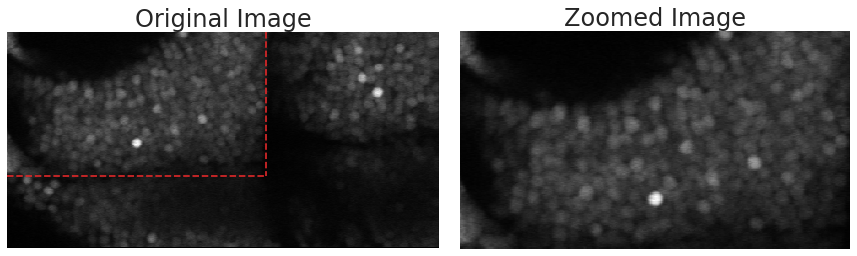

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Cropping parameters.
x_frac = 0.60
y_frac = 0.67

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Cropping and thresholding.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define boundaries for cropping
n_acq, n_row, n_col = green.shape
m = int(n_col * x_frac)
n = int(n_row * y_frac) 

## Crop image.
zgreen = green[:,:n,:m]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize convas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Plot original.
sns.heatmap(green.sum(axis=0), cmap='binary_r', square=True, cbar=False, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Original Image');

## Demarcate boundaries.
axes[0].hlines(n, 0, m, linestyle='--', color='#d62728')
axes[0].vlines(m, 0, n, linestyle='--', color='#d62728')

## Plot zoomed image.
sns.heatmap(zgreen.sum(axis=0), cmap='binary_r', square=True, cbar=False, ax=axes[1])
axes[1].set(xticks=[], yticks=[], title='Zoomed Image');

plt.subplots_adjust(left=0, right=1, wspace=0)

### Step 3b: Generate Design Matrix
In this step, we perform mass univariate regression (inspired by conventional fMRI analysis) in order to detect pixels responsive to either stimulus motion (i.e. clockwise or counter-clockwise). In mass univariate analysis, a linear regression model is fitted to each pixel separately. This requires unsurprisingly a design matrix, or a set of independent (predictor) variables to regress against our dependent variable (fluorescence over time). Our design matrix will be comprised of three variables: 

1. **Intercept** ($\beta_0$): an offset term, used to demean the timeseries (i.e. remove any offset). 
2. **CW coefficient** ($\beta_1$): measuring the response, in luminance, of a given pixel to clockwise motion.
3. **CCW coefficient** ($\beta_2$): measuring the response, in luminance, of a given pixel to counter-clockwise motion.

The intercept term is easy to generate; it is simply a column of 1s in our design matrix ($\beta_0$ thus represents the mean luminance of a given pixel). The CW and CCW coefficients are easy to define but more difficult to generate. These predictors need to represent the *expected* luminance response of a neuron if it were indeed responsive to either CW or CCW motion. This requires some knowledge of what a calcium response ought to look in an active neuron. Here we may two assumptions: 

1. The **duration** of the response ought to be locked to the duration of the stimulus. In other words, a CW-encoding neuron should respond the entire time the stimulus is moving CW. We also assume the response is instantaneous, with no lag after stimulus offset.
2. The **amplitude** of the response ought to be locked to the velocity of the stimulus. In other words, a CW-encoding neuron should respond with greater amplitude when the stimulus is quickly (in contrast to slowly) moving CW. 

Thus, we construct a predicted timeseries, for each condition (CW, CCW), such that the values are positive when the stimulus is moving in the corresponding direction and zero otherwise. Furthermore, we construct a timeseries that is more positive when the stimulus is moving quickly. Given that the stimulus does in fact change rotational velocity over epochs, we here elect to represent the predicted response as a half-sine wave (i.e. an inverse-U). The half-sine wave matches the increasing-then-decreasing rotational velocity pattern of the visual stimulus. We match the half-sine waves to the epochs below:

| # | Motion | Onset (s) | Duration |
|---|:------:|:---------:|:--------:|
| 1 | CW     | 18        | 3        |
| 2 | CCW    | 21        | 5        |
| 3 | CW     | 26        | 5        |
| 4 | CCW    | 31        | 5        |
| 5 | CW     | 36        | 5        |
| 6 | CCW    | 41        | 5        |
| 7 | CW     | 46        | 2        |

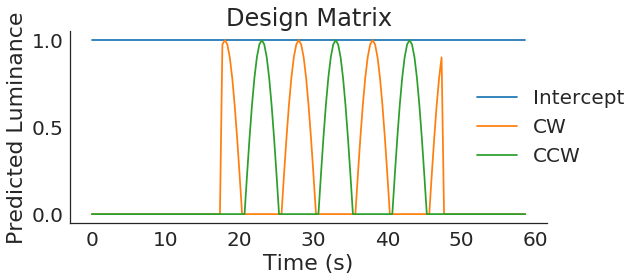

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Estimate metadata.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Identify the indices of times during stimulus stimulus presentation
## from the average amplitude of the red light. 
red_mean = np.apply_over_axes(np.mean, red, [1,2]).squeeze()
indices, = np.where(red_mean > 0.05)

## Estimate the sampling frequency based on the stimulus presentation
## information. This is necessary as no such information is encoded
## in the TIFF file.
total_time = 30 # seconds
sfreq = indices.shape[0] / total_time
times = (np.arange(n_acq) / sfreq)

## Identify the event boundaries for each of the epochs described above.
## This is necessary as the recording included no triggers to demarcate
## the onset or offset of events.
durations = [0, 3, 5, 5, 5, 5, 5, 2]
events = (indices.min() + np.cumsum(durations) * sfreq).astype(int)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Construct design matrix.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define half-sine basis function.
basis = np.sin(0.5 * np.pi * np.linspace(0,2,15))

## Preallocate space. Add intercept term.
X = np.zeros((zgreen.shape[0], 3))
X[:,0] = 1

## Add CW and CCW predictors.
for i in np.arange(0, events.size-1):

    if not i:
        X[events[i]:events[i+1],i%2+1] = basis[-(events[i+1]-events[i]):] # Truncate first event
    else:
        X[events[i]:events[i+1],i%2+1] = basis[:(events[i+1]-events[i])]  # Add remaining events.
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot predictors.
for arr, label in zip(X.T, ['Intercept', 'CW', 'CCW']):
    ax.plot(times, arr, label=label)
    
## Add information.
ax.set(xlabel='Time (s)', ylabel='Predicted Luminance', title='Design Matrix')
ax.legend(loc=7, bbox_to_anchor=(1.2,0.5))

sns.despine()
plt.tight_layout()

### Step 3c: Mass Univariate Regression

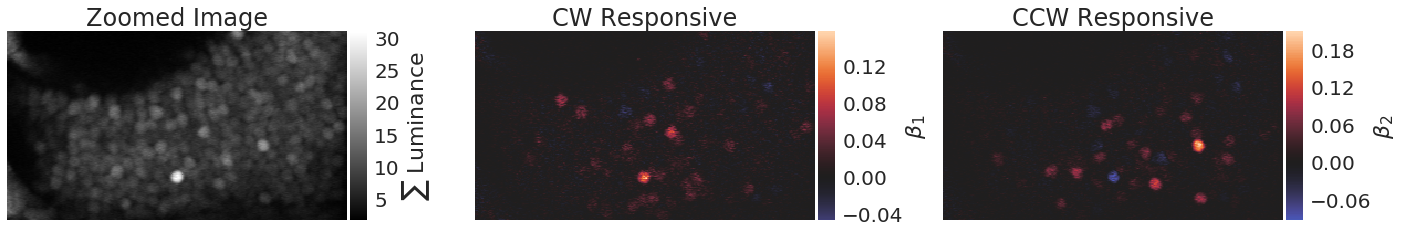

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def dot_self(arr):
    return np.inner(arr,arr)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Regression.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Reshape dependent variables.
n_acq, n_row, n_col = zgreen.shape
y = zgreen.reshape(n_acq, n_row*n_col)

## Perform OLS.
b, _, _, _ = np.linalg.lstsq(X, y)

## Compute standard error. Compared against Statsmodels OLS output.
residuals = y - X.dot(b)
sigma_sq = np.apply_along_axis(dot_self, 0, residuals) / np.subtract(*X.shape)
se = np.sqrt( np.outer(np.diag(np.linalg.inv(X.T.dot(X))), sigma_sq) )

## Return dependent variables to original shape.
b = b.reshape(X.shape[-1], n_row, n_col)
se = se.reshape(X.shape[-1], n_row, n_col)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(18,6))

cmaps = ['binary_r', None, None]
centers = [None, 0, 0]
ylabels = [r'$\sum$ Luminance', r'$\beta_1$', r'$\beta_2$']
titles = ['Zoomed Image', 'CW Responsive', 'CCW Responsive']

for ax, arr, cmap, center, ylabel, title in zip(axes, [zgreen.sum(axis=0), b[1], b[2]], 
                                   cmaps, centers, ylabels, titles):
    
    ## Make colorbar divider.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    ## Plot array.
    sns.heatmap(arr, cmap=cmap, center=center, square=True, cbar=True, ax=ax, cbar_ax=cax)
    ax.set(xticks=[], yticks=[], title=title)
    cax.set_ylabel(ylabel, labelpad=0)

plt.subplots_adjust(left=0, right=1, wspace=0.3)

### Step 3d: Significance Testing

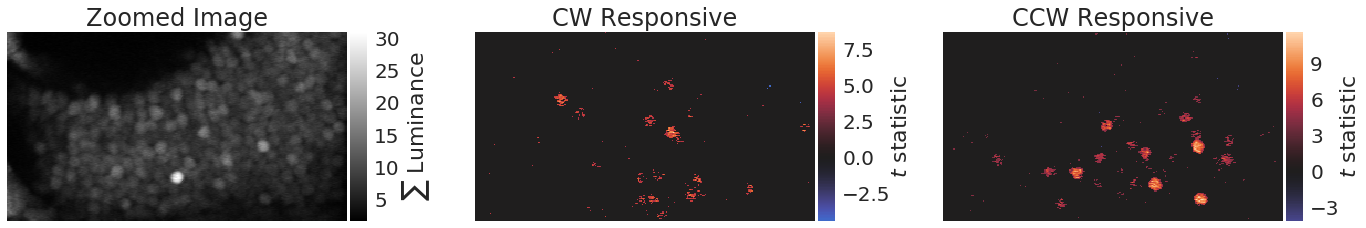

In [5]:
from scipy.stats import t
from mne.stats import fdr_correction

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute t-statistics / p-values.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute t-statistics.
tvals = b / se

## Compute p-values.
pvals = t.sf(np.abs(tvals), df=np.subtract(*X.shape)) * 2 # Two-sided

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Multiple comparisons corrections.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## False-discovery rate (FDR).
alpha = 0.01
for n in np.arange(pvals.shape[0]):
    _, pvals[n] = fdr_correction(pvals[n], alpha=alpha)
    
## Threshold t-statistics.
tvals = np.where(pvals < alpha, tvals, 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(18,6))

cmaps = ['binary_r', None, None]
centers = [None, 0, 0]
ylabels = [r'$\sum$ Luminance', r'$t$ statistic', r'$t$ statistic']
titles = ['Zoomed Image', 'CW Responsive', 'CCW Responsive']

for ax, arr, cmap, center, ylabel, title in zip(axes, [zgreen.sum(axis=0), tvals[1], tvals[2]], 
                                   cmaps, centers, ylabels, titles):
    
    ## Make colorbar divider.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    ## Plot array.
    sns.heatmap(arr, cmap=cmap, center=center, square=True, cbar=True, ax=ax, cbar_ax=cax)
    ax.set(xticks=[], yticks=[], title=title)
    cax.set_ylabel(ylabel, labelpad=0)

plt.subplots_adjust(left=0, right=1, wspace=0.3)

### Digression: Compute Overlap

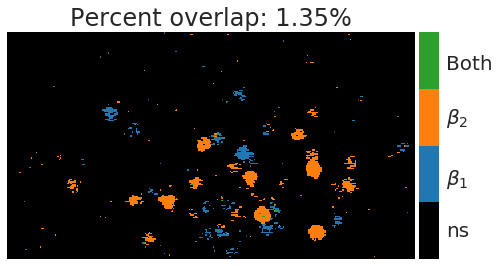

In [6]:
from matplotlib.colors import ListedColormap

## Discreteize overlap. 
arr = (tvals[1:].astype(bool).T * np.arange(1,3)).T.sum(axis=0)
overlap = (arr > 2).sum() / (arr > 0).sum()

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,6))
cmap = sns.color_palette(n_colors=3).as_hex()
cmap.insert(0,'k')

## Make colorbar divider.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

## Plot array.
sns.heatmap(arr, cmap=ListedColormap(cmap),  square=True, cbar=True, ax=ax, cbar_ax=cax)
ax.set(xticks=[], yticks=[], title='Percent overlap: %0.2f%%' %(overlap * 1e2))

## Update colorbar.
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.4,1.1,1.9,2.6])
cbar.set_ticklabels(['ns',r'$\beta_1$',r'$\beta_2$','Both'])

plt.subplots_adjust(left=0, right=1, wspace=0.3)

### Step 3e: Plot Contours
See this [tutorial](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_clean_morpho.html).

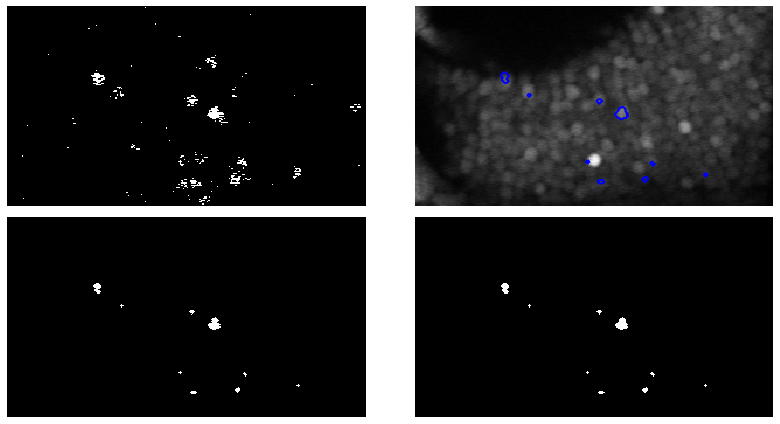

In [7]:
from scipy import ndimage

binary_img = tvals[1] > 0

## Remove small white regions
open_img = ndimage.binary_opening(binary_img)

## Remove small black hole
close_img = ndimage.binary_closing(open_img)

fig, axes = plt.subplots(2,2,figsize=(12,6))
sns.heatmap(binary_img, cmap='binary_r', center=0.5, square=True, ax=axes[0,0], xticklabels=[], yticklabels=[], cbar=False)

sns.heatmap(zgreen.sum(axis=0), cmap='binary_r', square=True, ax=axes[0,1], xticklabels=[], yticklabels=[], cbar=False)
axes[0,1].contour(close_img, [0.5], linewidths=2, colors='b')

sns.heatmap(open_img, cmap='binary_r', center=0.5, square=True, ax=axes[1,0], xticklabels=[], yticklabels=[], cbar=False)
sns.heatmap(close_img, cmap='binary_r', center=0.5, square=True, ax=axes[1,1], xticklabels=[], yticklabels=[], cbar=False)

plt.tight_layout()